In [7]:
import sys
from pathlib import Path
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Add project root to path
sys.path.append("/home/ji-liu/GitHub/off_road_nav")

from offroad_det_seg_rellis.dataset.rellis_classes import RELLIS_CLASSES, sorted_keys, RELLIS_CLASS_INDEX_MAP_INV

# Paths
DATA_ROOT = Path("/home/ji-liu/GitHub/off_road_nav/RELLIS/Rellis-3D")
SPLIT_DIR = Path("/home/ji-liu/GitHub/off_road_nav/offroad_det_seg_rellis/config")

# Sequences to process
SEQUENCES = ["00000", "00001", "00002", "00003", "00004"]
GRID_TYPE = "polar"

print(f"Data root: {DATA_ROOT}")
print(f"Sequences: {SEQUENCES}")
print(f"Grid type: {GRID_TYPE}")
print(f"\nRELLIS Classes ({len(RELLIS_CLASSES)} classes):")
for class_id in sorted_keys:
    print(f"  {class_id}: {RELLIS_CLASSES[class_id]}")


Data root: /home/ji-liu/GitHub/off_road_nav/RELLIS/Rellis-3D
Sequences: ['00000', '00001', '00002', '00003', '00004']
Grid type: polar

RELLIS Classes (20 classes):
  0: void
  1: dirt
  3: grass
  4: tree
  5: pole
  6: water
  7: sky
  8: vehicle
  9: object
  10: asphalt
  12: building
  15: log
  17: person
  18: fence
  19: bush
  23: concrete
  27: barrier
  31: puddle
  33: mud
  34: rubble


In [2]:
def load_split_list(split_file: Path) -> dict:
    """Load split list file and return dict mapping (seq_id, frame_idx) to split name."""
    split_dict = {}
    if not split_file.exists():
        print(f"Warning: Split file not found: {split_file}")
        return split_dict
    
    with open(split_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) >= 2:
                seq_id = parts[0]
                frame_idx = int(parts[1])
                split_dict[(seq_id, frame_idx)] = True
    return split_dict

# Load split lists
train_split = load_split_list(SPLIT_DIR / "split_list_train.lst")
val_split = load_split_list(SPLIT_DIR / "split_list_val.lst")
test_split = load_split_list(SPLIT_DIR / "split_list_test.lst")

print(f"Train samples: {len(train_split)}")
print(f"Val samples: {len(val_split)}")
print(f"Test samples: {len(test_split)}")
print(f"Total samples: {len(train_split) + len(val_split) + len(test_split)}")


Train samples: 10097
Val samples: 2159
Test samples: 1300
Total samples: 13556


In [3]:
def compute_class_statistics(sequences, data_root, grid_type):
    """Compute class statistics from all BEV segmentation maps."""
    # Initialize counters
    class_counts_all = defaultdict(int)  # Total pixel count per class
    class_counts_train = defaultdict(int)
    class_counts_val = defaultdict(int)
    class_counts_test = defaultdict(int)
    
    total_pixels_all = 0
    total_pixels_train = 0
    total_pixels_val = 0
    total_pixels_test = 0
    
    total_frames_all = 0
    total_frames_train = 0
    total_frames_val = 0
    total_frames_test = 0
    
    # Process each sequence
    for seq_id in sequences:
        bev_dir = data_root / seq_id / f"bev_seg_{grid_type}"
        
        if not bev_dir.exists():
            print(f"Warning: BEV directory not found: {bev_dir}")
            continue
        
        # Get all .npy files
        npy_files = sorted(bev_dir.glob("*.npy"))
        print(f"\nProcessing sequence {seq_id}: {len(npy_files)} frames")
        
        for npy_file in tqdm(npy_files, desc=f"Sequence {seq_id}", leave=False):
            try:
                frame_idx = int(npy_file.stem)
            except ValueError:
                continue
            
            # Load BEV map
            bev_map = np.load(npy_file).astype(np.int32)
            
            # Count pixels per class
            unique_classes, counts = np.unique(bev_map, return_counts=True)
            total_pixels = bev_map.size
            
            # Update all statistics
            for class_id, count in zip(unique_classes, counts):
                class_counts_all[class_id] += count
            total_pixels_all += total_pixels
            total_frames_all += 1
            
            # Update split-specific statistics
            if (seq_id, frame_idx) in train_split:
                for class_id, count in zip(unique_classes, counts):
                    class_counts_train[class_id] += count
                total_pixels_train += total_pixels
                total_frames_train += 1
            elif (seq_id, frame_idx) in val_split:
                for class_id, count in zip(unique_classes, counts):
                    class_counts_val[class_id] += count
                total_pixels_val += total_pixels
                total_frames_val += 1
            elif (seq_id, frame_idx) in test_split:
                for class_id, count in zip(unique_classes, counts):
                    class_counts_test[class_id] += count
                total_pixels_test += total_pixels
                total_frames_test += 1
    
    return {
        'all': {
            'class_counts': class_counts_all,
            'total_pixels': total_pixels_all,
            'total_frames': total_frames_all
        },
        'train': {
            'class_counts': class_counts_train,
            'total_pixels': total_pixels_train,
            'total_frames': total_frames_train
        },
        'val': {
            'class_counts': class_counts_val,
            'total_pixels': total_pixels_val,
            'total_frames': total_frames_val
        },
        'test': {
            'class_counts': class_counts_test,
            'total_pixels': total_pixels_test,
            'total_frames': total_frames_test
        }
    }

# Compute statistics
print("Computing class statistics from BEV segmentation maps...")
stats = compute_class_statistics(SEQUENCES, DATA_ROOT, GRID_TYPE)


Computing class statistics from BEV segmentation maps...

Processing sequence 00000: 2847 frames



Processing sequence 00001: 2319 frames



Processing sequence 00002: 4147 frames



Processing sequence 00003: 2184 frames



Processing sequence 00004: 2059 frames


In [10]:
import numpy as np
def print_statistics(stats_dict, split_name, class_counts, total_pixels, total_frames):
    """Print statistics for a given split."""
    print(f"\n{'='*80}")
    print(f"{split_name.upper()} SET STATISTICS")
    print(f"{'='*80}")
    print(f"Total frames: {total_frames:,}")
    print(f"Total pixels: {total_pixels:,}")
    print(f"\nClass Distribution:")
    print(f"{'Class ID':<10} {'Class Name':<20} {'Pixel Count':<15} {'Proportion (%)':<15}")
    print("-" * 80)
    
    # Sort by class ID
    class_counts_list = list(class_counts.items())
    class_counts_list_sort_by_count = sorted(class_counts_list, key=lambda x: x[1], reverse=True)
    proportions = {}
    
    for class_id in [x[0] for x in class_counts_list_sort_by_count]:
        count = class_counts[class_id]
        proportion = (count / total_pixels * 100) if total_pixels > 0 else 0.0
        proportions[class_id] = proportion
        ori_class_id = RELLIS_CLASS_INDEX_MAP_INV[class_id]
        class_name = RELLIS_CLASSES[ori_class_id]
        print(f"{class_id:<10} {class_name:<20} {count:>15,} {proportion:>15.4f}")
    
    # Summary
    print(f"\n{'Total':<10} {'All Classes':<20} {total_pixels:>15,} {100.0:>15.4f}")
    
    return proportions

# Print statistics for all splits
all_proportions = print_statistics(
    stats, 'all', 
    stats['all']['class_counts'], 
    stats['all']['total_pixels'],
    stats['all']['total_frames']
)

train_proportions = print_statistics(
    stats, 'train',
    stats['train']['class_counts'],
    stats['train']['total_pixels'],
    stats['train']['total_frames']
)

val_proportions = print_statistics(
    stats, 'val',
    stats['val']['class_counts'],
    stats['val']['total_pixels'],
    stats['val']['total_frames']
)

test_proportions = print_statistics(
    stats, 'test',
    stats['test']['class_counts'],
    stats['test']['total_pixels'],
    stats['test']['total_frames']
)



ALL SET STATISTICS
Total frames: 13,556
Total pixels: 6,710,220

Class Distribution:
Class ID   Class Name           Pixel Count     Proportion (%) 
--------------------------------------------------------------------------------
2          grass                      3,807,465         56.7413
14         bush                       1,264,307         18.8415
0          void                         967,920         14.4246
3          tree                         333,249          4.9663
18         mud                          168,224          2.5070
15         concrete                      65,240          0.9722
17         puddle                        43,387          0.6466
12         person                        22,751          0.3390
19         rubble                        15,694          0.2339
16         barrier                        9,381          0.1398
13         fence                          4,313          0.0643
11         log                            4,088          0.0609
5

In [11]:
# Create a comparison table
import pandas as pd

# Prepare data for DataFrame
comparison_data = []
for class_id in sorted_keys:
    class_name = RELLIS_CLASSES[class_id]
    
    all_count = stats['all']['class_counts'].get(class_id, 0)
    all_prop = (all_count / stats['all']['total_pixels'] * 100) if stats['all']['total_pixels'] > 0 else 0.0
    
    train_count = stats['train']['class_counts'].get(class_id, 0)
    train_prop = (train_count / stats['train']['total_pixels'] * 100) if stats['train']['total_pixels'] > 0 else 0.0
    
    val_count = stats['val']['class_counts'].get(class_id, 0)
    val_prop = (val_count / stats['val']['total_pixels'] * 100) if stats['val']['total_pixels'] > 0 else 0.0
    
    test_count = stats['test']['class_counts'].get(class_id, 0)
    test_prop = (test_count / stats['test']['total_pixels'] * 100) if stats['test']['total_pixels'] > 0 else 0.0
    
    comparison_data.append({
        'Class ID': class_id,
        'Class Name': class_name,
        'All %': f"{all_prop:.4f}",
        'Train %': f"{train_prop:.4f}",
        'Val %': f"{val_prop:.4f}",
        'Test %': f"{test_prop:.4f}",
        'All Count': all_count,
        'Train Count': train_count,
        'Val Count': val_count,
        'Test Count': test_count,
    })

df = pd.DataFrame(comparison_data)
print("\n" + "="*120)
print("CLASS DISTRIBUTION COMPARISON")
print("="*120)
print(df.to_string(index=False))



CLASS DISTRIBUTION COMPARISON
 Class ID Class Name   All % Train %   Val %  Test %  All Count  Train Count  Val Count  Test Count
        0       void 14.4246 14.6782 12.7062 15.3083     967920       733619     135792       98509
        1       dirt  0.0000  0.0000  0.0000  0.0000          0            0          0           0
        3      grass  4.9663  4.7757  5.9606  4.7950     333249       238692      63701       30856
        4       tree  0.0066  0.0066  0.0000  0.0179        443          328          0         115
        5       pole  0.0560  0.0751  0.0000  0.0000       3755         3755          0           0
        6      water  0.0000  0.0000  0.0000  0.0000          0            0          0           0
        7        sky  0.0000  0.0000  0.0000  0.0002          2            1          0           1
        8    vehicle  0.0000  0.0000  0.0000  0.0000          0            0          0           0
        9     object  0.0000  0.0000  0.0000  0.0000          1      

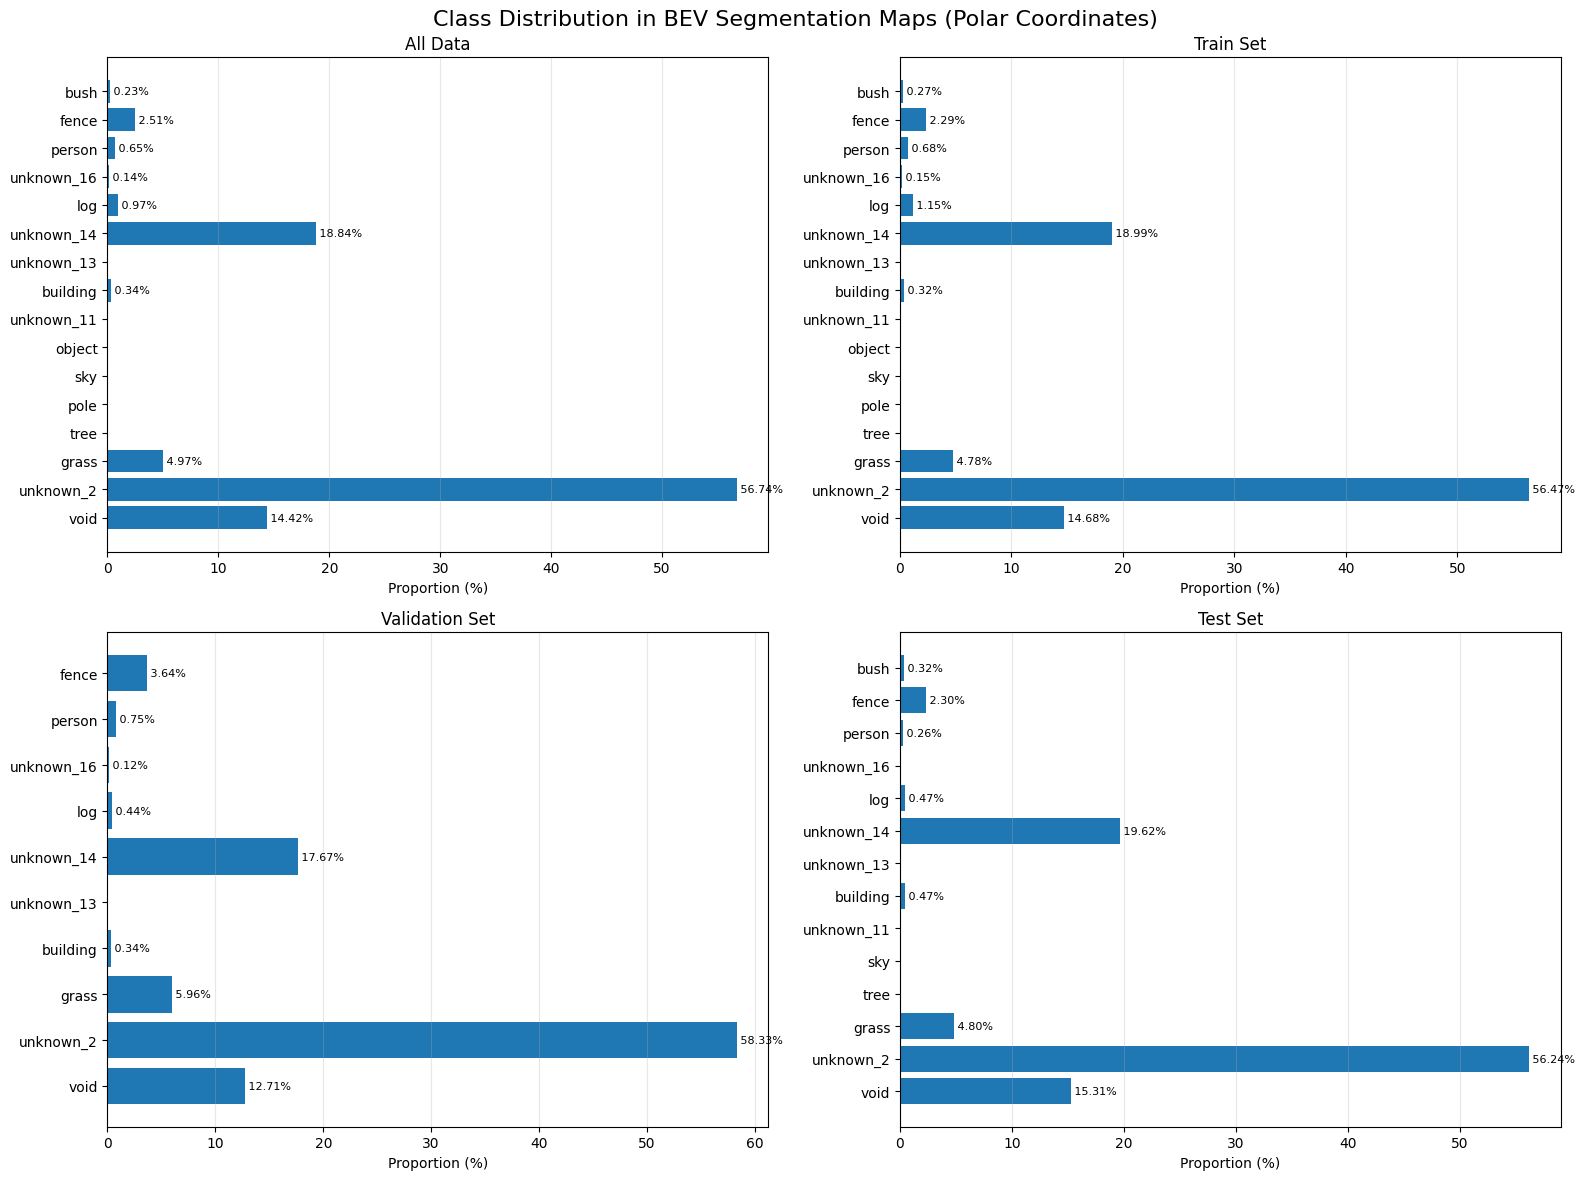

In [12]:
# Visualize class distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Class Distribution in BEV Segmentation Maps (Polar Coordinates)', fontsize=16)

splits = ['all', 'train', 'val', 'test']
titles = ['All Data', 'Train Set', 'Validation Set', 'Test Set']

for idx, (split, title) in enumerate(zip(splits, titles)):
    ax = axes[idx // 2, idx % 2]
    
    class_counts = stats[split]['class_counts']
    sorted_class_ids = sorted(class_counts.keys())
    class_names = [RELLIS_CLASSES.get(cid, f"unknown_{cid}") for cid in sorted_class_ids]
    counts = [class_counts.get(cid, 0) for cid in sorted_class_ids]
    total = stats[split]['total_pixels']
    proportions = [(c / total * 100) if total > 0 else 0.0 for c in counts]
    
    bars = ax.barh(class_names, proportions)
    ax.set_xlabel('Proportion (%)', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, prop) in enumerate(zip(bars, proportions)):
        if prop > 0.1:  # Only show label if proportion is significant
            ax.text(prop, i, f' {prop:.2f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()


In [13]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nDataset Overview:")
print(f"  Total sequences processed: {len(SEQUENCES)}")
print(f"  Sequences: {', '.join(SEQUENCES)}")
print(f"  Grid type: {GRID_TYPE}")

print(f"\nFrame Counts:")
print(f"  All: {stats['all']['total_frames']:,} frames")
print(f"  Train: {stats['train']['total_frames']:,} frames ({stats['train']['total_frames']/stats['all']['total_frames']*100:.2f}%)")
print(f"  Val: {stats['val']['total_frames']:,} frames ({stats['val']['total_frames']/stats['all']['total_frames']*100:.2f}%)")
print(f"  Test: {stats['test']['total_frames']:,} frames ({stats['test']['total_frames']/stats['all']['total_frames']*100:.2f}%)")

print(f"\nPixel Counts:")
print(f"  All: {stats['all']['total_pixels']:,} pixels")
print(f"  Train: {stats['train']['total_pixels']:,} pixels ({stats['train']['total_pixels']/stats['all']['total_pixels']*100:.2f}%)")
print(f"  Val: {stats['val']['total_pixels']:,} pixels ({stats['val']['total_pixels']/stats['all']['total_pixels']*100:.2f}%)")
print(f"  Test: {stats['test']['total_pixels']:,} pixels ({stats['test']['total_pixels']/stats['all']['total_pixels']*100:.2f}%)")

print(f"\nNumber of Classes Present:")
for split in ['all', 'train', 'val', 'test']:
    num_classes = len([c for c in stats[split]['class_counts'].keys() if stats[split]['class_counts'][c] > 0])
    print(f"  {split.capitalize()}: {num_classes} classes")



SUMMARY STATISTICS

Dataset Overview:
  Total sequences processed: 5
  Sequences: 00000, 00001, 00002, 00003, 00004
  Grid type: polar

Frame Counts:
  All: 13,556 frames
  Train: 10,097 frames (74.48%)
  Val: 2,159 frames (15.93%)
  Test: 1,300 frames (9.59%)

Pixel Counts:
  All: 6,710,220 pixels
  Train: 4,998,015 pixels (74.48%)
  Val: 1,068,705 pixels (15.93%)
  Test: 643,500 pixels (9.59%)

Number of Classes Present:
  All: 16 classes
  Train: 16 classes
  Val: 10 classes
  Test: 14 classes


In [14]:
# Check for frames not in any split
print("\n" + "="*80)
print("DATA COVERAGE ANALYSIS")
print("="*80)

total_frames_in_splits = stats['train']['total_frames'] + stats['val']['total_frames'] + stats['test']['total_frames']
unmatched_frames = stats['all']['total_frames'] - total_frames_in_splits

print(f"\nFrame Coverage:")
print(f"  Total frames in BEV maps: {stats['all']['total_frames']:,}")
print(f"  Frames in train/val/test splits: {total_frames_in_splits:,}")
print(f"  Unmatched frames (not in any split): {unmatched_frames:,} ({unmatched_frames/stats['all']['total_frames']*100:.2f}%)")

if unmatched_frames > 0:
    print(f"\n  Note: Some frames in the BEV maps are not assigned to any split.")
    print(f"  These frames are included in 'all' statistics but not in train/val/test splits.")

# Class imbalance analysis
print(f"\nClass Imbalance Analysis (All Data):")
class_proportions = []
for class_id in sorted_keys:
    count = stats['all']['class_counts'].get(class_id, 0)
    prop = (count / stats['all']['total_pixels'] * 100) if stats['all']['total_pixels'] > 0 else 0.0
    class_name = RELLIS_CLASSES[class_id]
    class_proportions.append((class_id, class_name, prop, count))

# Sort by proportion
class_proportions.sort(key=lambda x: x[2], reverse=True)

print(f"\nTop 5 Most Common Classes:")
for i, (class_id, class_name, prop, count) in enumerate(class_proportions[:5]):
    print(f"  {i+1}. {class_name} (ID: {class_id}): {prop:.4f}% ({count:,} pixels)")

print(f"\nTop 5 Least Common Classes (excluding zero):")
non_zero = [(cid, cname, prop, cnt) for cid, cname, prop, cnt in class_proportions if cnt > 0]
if len(non_zero) >= 5:
    for i, (class_id, class_name, prop, count) in enumerate(non_zero[-5:]):
        print(f"  {i+1}. {class_name} (ID: {class_id}): {prop:.4f}% ({count:,} pixels)")
else:
    for i, (class_id, class_name, prop, count) in enumerate(non_zero):
        print(f"  {i+1}. {class_name} (ID: {class_id}): {prop:.4f}% ({count:,} pixels)")



DATA COVERAGE ANALYSIS

Frame Coverage:
  Total frames in BEV maps: 13,556
  Frames in train/val/test splits: 13,556
  Unmatched frames (not in any split): 0 (0.00%)

Class Imbalance Analysis (All Data):

Top 5 Most Common Classes:
  1. void (ID: 0): 14.4246% (967,920 pixels)
  2. grass (ID: 3): 4.9663% (333,249 pixels)
  3. fence (ID: 18): 2.5070% (168,224 pixels)
  4. log (ID: 15): 0.9722% (65,240 pixels)
  5. person (ID: 17): 0.6466% (43,387 pixels)

Top 5 Least Common Classes (excluding zero):
  1. bush (ID: 19): 0.2339% (15,694 pixels)
  2. pole (ID: 5): 0.0560% (3,755 pixels)
  3. tree (ID: 4): 0.0066% (443 pixels)
  4. sky (ID: 7): 0.0000% (2 pixels)
  5. object (ID: 9): 0.0000% (1 pixels)
